In [1]:
include("astrobee_se3_script.jl")
using Plots


# Helper functions

## Main GuSTO function

In [2]:
function solve_gusto(model, N, MAX_ITERATIONS_NB, verbose = true, Xp = [], Up = [])
    
    if (Xp == [] && Up == [])
        Xp,Up = initialize_trajectory(model, N)
    elseif Up == []
        println("GuSTO X has been warm-started.")
        Up = zeros(model.u_dim, N-1)
    else
        println("GuSTO has been warm-started.")
    end
    X, U  = copy(Xp)  , copy(Up) 

    SCPproblem = GuSTOProblem(model, N, Xp, Up)

    x_dim, u_dim = model.x_dim, model.u_dim

    Delta0, omega0, omegamax, 
        epsilon, rho0, rho1, 
        beta_succ, beta_fail, gamma_fail, 
        convergence_threshold = get_initial_gusto_parameters(model)

    Delta = Delta0
    omega = omega0

    X_all, U_all = [], []
    push!(X_all, copy(X))
    push!(U_all, copy(U))

    B_success = false
    it = 0

    while it<MAX_ITERATIONS_NB && 
            !(it!=0 && it!=1 && it!=2 && it!=3 && B_success && 
                convergence_metric(model,X,U,Xp,Up)<convergence_threshold) &&
            omega<omegamax
        if verbose
            println("-----------")
            println("Iteration $it")
            println("metric=$(convergence_metric(model,X,U,Xp,Up))")
            println("-----------")
        end

        Xp = copy(X)
        Up = copy(U)

        model.f, model.A, model.B = compute_dynamics(model, Xp, Up)

        reset_problem(SCPproblem, model)
        set_parameters(SCPproblem, model, Xp, Up, omega, Delta)
        define_cost(SCPproblem, model)
        define_constraints(SCPproblem, model)

        JuMP.optimize!(SCPproblem.solver_model)    

        # get solution
        X_sol = JuMP.value.(SCPproblem.X)
        U_sol = JuMP.value.(SCPproblem.U)

        # -----------
        # GuSTO Logic
        if it > 3
            if is_in_trust_region(model, X_sol, U_sol, Xp, Up, Delta)
                rho = accuracy_ratio(SCPproblem, model, X_sol, U_sol, Xp, Up)

                if rho > rho1
                    if verbose
                        println("Reject solution.")
                    end
                    Delta = beta_fail * Delta
                    omega     = omega
                    B_success = false

                else
                    if verbose
                        println("Accept solution.")
                    end
                    X = copy(X_sol)
                    U = copy(U_sol)
                    B_success = true
                    if rho < rho0
                        Delta = min(beta_succ*Delta, Delta0)
                    else
                        Delta = Delta
                    end
                    if satisfies_state_inequality_constraints(SCPproblem, model, X_sol, U_sol, Xp, Up, Delta)
                        omega = omega0
                    else
                        if verbose
                            println("Solution does not satisfy state constraints, increasing omega.")
                        end
                        omega = gamma_fail * omega
                        B_success = false
                    end
                end
            else
                if verbose
                    println("Reject solution (Outside trust region)")
                end
                Delta = Delta
                omega     = gamma_fail * omega
                B_success = false
            end

        else # always accept first solution
            X = copy(X_sol)
            U = copy(U_sol)
        end


        # -----------

        push!(X_all, copy(X))
        push!(U_all, copy(U))


        it += 1

        diff_with_prev = norm(copy(X) - copy(Xp), Inf)
        if verbose
            println("x(k) - x(k-1) = $diff_with_prev")
            println("Parameters:")
            println("omega=$omega")
            println("delta=$Delta")
        end
    end
    curr_conv_metric = convergence_metric(model,X,U,Xp,Up)
    if (B_success && 
                curr_conv_metric<convergence_threshold)
        if verbose
            println("Converged")
        end
        isConverged = true
    else
        if verbose
            println("Not converged. Metric =$curr_conv_metric")
        end
        isConverged = false
    end
    return isConverged, it, X_all, U_all
end

solve_gusto (generic function with 4 methods)

## Function to check if point is inside any obstacle

In [3]:
function isInsideObstacle(x, model)
    isInside = false
    for obs in model.obstacles
        center = obs[1]
        radius = obs[2]
        if norm(x[1:3] - center) < radius
            isInside = true
            return isInside
        end
    end
    for obs in model.poly_obstacles
        center = obs.c
        dx = obs.dx
        dy = obs.dy
        dz = obs.dz
        x_max = center[1]+dx
        y_max = center[2]+dy
        z_max = center[3]+dz
        x_min = center[1]-dx
        y_min = center[2]-dy
        z_min = center[3]-dz
        if (x[1]<= x_max && x[1] >= x_min && 
            x[2]<= y_max && x[2] >= y_min &&
            x[3]<= z_max && x[3] >= z_min)
            isInside = true
            return isInside
        end
    end
    return isInside
end

isInsideObstacle (generic function with 1 method)

## This function calls the main solve_gusto() function but in addition also does some sanity checks
### - Checks if the initial and final points passed in valid according to the model (i.e. outside all obstacles)

In [4]:
function findTrueGuSTOSolution(x_init, x_final, model = :None, verbose = false, Xinit = [], Uinit = [])
    N = 50
    MAX_ITERATIONS_NB = 100
    
    if model == :None
        println("No model supplied. Using spheres model.")
        model = getModelWithCornerSpheres()
    end
    
    isConverged = false
    X_all = []
    U_all = []
    numIter = 0

    problemNumber = 0

    train_input_collected = Array{Float64}(undef,0,26)
    train_output_collected = Array{Float64}(undef,0,944)

    if isInsideObstacle(x_init, model)
        println("x_init is inside an obstacle. Not valid.")
        return model, isConverged, X_all, U_all
    end
    if isInsideObstacle(x_final, model)
        println("x_final is inside an obstacle. Not valid.")
        return model, isConverged, X_all, U_all
    end
    if norm(x_final[1:3] - x_init[1:3])<1.0
        println("x_init and x_final too close. Not valid.")
        return model, isConverged, X_all, U_all
    end


    model.x_init = x_init
    model.x_final = x_final
    
    println("Starting to solve GuSTO")
    try
        isConverged, numIter, X_all, U_all = solve_gusto(model, N, MAX_ITERATIONS_NB, verbose, Xinit, Uinit)
    catch e
        isConverged = false
        println("$e")
    end
    println("Converged: $isConverged")

    return model, isConverged, numIter, X_all, U_all
end



findTrueGuSTOSolution (generic function with 5 methods)

## Get model on which data was collected and training done

In [5]:
function getModelWithTwoPolyObsOneAtCorner()
    N = 50
    MAX_ITERATIONS_NB = 100

    model = AstrobeeSE3()

    # Set up environment
    model.x_max[1:3] = [10.0; 10.0; 1.0]
    model.x_min[1:3] = [0.0; 0.0; 0.0]

    obstacles = []
    # obs = [[0.0,0.0,0.0], 6.0]
    # push!(obstacles, obs)
    model.obstacles = obstacles

    poly_obstacles = []
    obs = PolygonalObstacle([2.5,2.5,0], [5.0, 5.0, 2.0])
    push!(poly_obstacles, obs)
    obs = PolygonalObstacle([7.0,3.0,0], [1.0, 1.0, 2.0])
    push!(poly_obstacles, obs)
    model.poly_obstacles = poly_obstacles

    model.tf_guess = 110.
    model.convergence_threshold = 0.7
    
    return model
end

getModelWithTwoPolyObsOneAtCorner (generic function with 1 method)

## Plotting helper functions

In [6]:
function plot_env_and_trajs(model, X_all, labls = :None)
    N = length(X_all)
    if labls == :None
        labls = fill("",(size(X_all,1),1))
    end
    
    idx = [1,2]
    local fig
    fig = plot(framestyle = :box)
    for iter = 1:length(X_all)
        X = X_all[iter]
        plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter])
    end

    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black,
                legend = false, fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[idx[1]],model.x_max[idx[1]]))
    ylims!((model.x_min[idx[2]],model.x_max[idx[2]]))
    plot!(leg = true)
    return fig
end

plot_env_and_trajs (generic function with 2 methods)

# Example problem

In [7]:
x_start= [0.9375, 8.0, 0.2]
x_goal = [7.5, 2.1875, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")
X_soln = X_all_true[end]

Starting to solve GuSTO

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Converged: true
GuSTO solve time = 80.792078306 (75 iterations)


13×50 Array{Float64,2}:
 0.9375       0.944488     0.967469    …   7.47717      7.49912    
 8.0          7.99703      7.9871          2.18022      2.18656    
 0.2          0.201991     0.208499        0.510111     0.500757   
 0.0          0.00622526   0.0142492       0.00977396   0.000996026
 0.0         -0.00264753  -0.00619362      0.00282253   0.000980447
 0.0          0.00177338   0.00402518  …  -0.00416688  -0.000988624
 0.0         -5.77994e-9  -2.69324e-8     -6.48638e-8  -1.24902e-11
 0.0          4.1495e-9    1.62849e-8      4.88106e-8   4.22008e-13
 0.0          0.00148168   0.0063624       1.00006      1.0        
 1.0          1.00002      1.00025         0.00395786   2.61709e-7 
 0.0         -0.00263968  -0.00604587  …  -0.0035266   -5.73095e-6 
 1.7579e-26   7.38143e-9   1.39144e-8     -5.77873e-8  -9.86032e-11
 0.0          1.02981e-8   2.73954e-8      4.34626e-8   7.51279e-11

# Plot solution in 2D

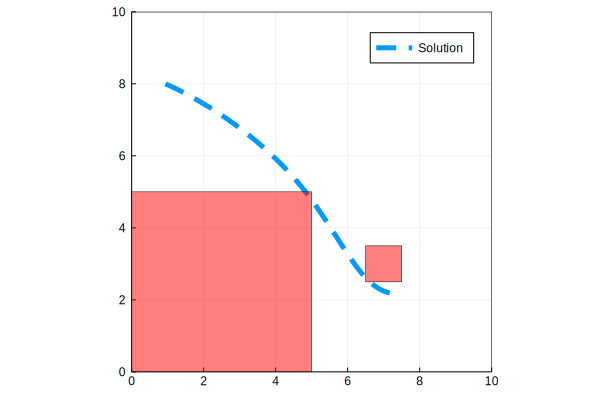

In [8]:
plot_env_and_trajs(model, [X_all_true[end]], ["Solution"])


# Plot solution in 3D

In [9]:
# using BulletCollision

using Plots
# using RigidBodySim, RigidBodyDynamics
using MeshCat, MeshCatMechanisms
using CoordinateTransformations
using Interact, Reactive
# using MAT, FileIO, MeshIO
using MechanismGeometries
# using ForwardDiff
import GeometryTypes: HyperRectangle, HyperSphere, HomogenousMesh, HyperCube
# import ColorTypes: RGB, RGBA

# using StaticArrays, DataStructures
# using JuMP, Convex
# using Ipopt, Mosek, SCS
# using MosekTools
# using Gurobi
# using MathProgBase, MathOptInterface
# using NLsolve, DifferentialEquations

# using MAT
using GeometryTypes
using FillArrays
using LinearAlgebra

using AstrobeeRobot
using ColorTypes




N = 50
# Animate Astrobee trajectory
vis = Visualizer()
delete!(vis)


# vis[:goal]
# for (idx,obs) in enumerate(env.keepout_zones)
#     setobject!(vis[:goal][:goal], 
#         Object(HyperSphere(Point3f0(x_goal[1:3]), 0.1f0),
#             MeshBasicMaterial(color=RGBA(0,1.0,0.,0.3))))
# end

# keepin_zones = []
# push!(keepin_zones,
#   HyperRectangle(Vec3f0([0.0,0.0,0.0]), Vec3f0([10.0,10.0,2.0])))
# vis[:workspace]
# for (idx,ws) in enumerate(keepin_zones)
#     if idx in (5,8)
#         setobject!(vis[:workspace][Symbol(string("ws",idx))],
#             Object(ws, MeshBasicMaterial(color=RGBA(0.95,0.93,0.26,0.3), depthWrite=false)))
#     else
#         setobject!(vis[:workspace][Symbol(string("ws",idx))],
#             Object(ws, MeshBasicMaterial(color=RGBA(0.95,0.93,0.26,0.3))))
#     end
# end

# vis[:obstacle]
# for (idx,ws) in enumerate(env.obstacle_set)
#     setobject!(vis[:workspace][Symbol(string("ws",idx+length(env.keepin_zones)))],
#         Object(ws,MeshBasicMaterial(color=RGBA(0.95,0.26,0.26,0.3))))
# end

obstacles = []
# push!(obstacles,
#   HyperSphere(Point3f0([0.4,-0.10,0.]), Float32(0.1)))

# push!(obstacles,
#   HyperCube(Vec3f0([2.5,2.5,0.5]), Float32(1.0)))

push!(obstacles,
  HyperRectangle(Vec3f0([0.0,0.0,0.0]), Vec3f0([5.0,5.0,1.0])))

push!(obstacles,
  HyperRectangle(Vec3f0([6.5,2.5,0.0]), Vec3f0([1.0,1.0,1.0])))

vis[:obstacle]
for (idx,ws) in enumerate(obstacles)
    setobject!(vis[:workspace][Symbol(string("ws",idx+1))],
        Object(ws,MeshBasicMaterial(color=RGBA(0.95,0.26,0.26,0.3))))
end

# setobject!(vis[:workspace][Symbol(string("mine"))], Object(Astrobee(), Vec3f0([0.0,0.0,0.0])))

# verts = rand(Point3f0, 100_000)
# @show typeof(verts)
verts = Array{Point{3,Float32},1}()
for rep in 1:100
    for j in 1:size(X_soln, 2)
        push!(verts, Point3f0(X_soln[1:3,j]+rand(3)/100))
    end
end
colors = [RGB(Point3f0([0,0,0])...) for p in verts]
setobject!(vis, PointCloud(verts, colors))

ab = Astrobee()
mvis = MechanismVisualizer(
    ab.mechanism,
    URDFVisuals(AstrobeeRobot.urdfpath(), package_path=[dirname(dirname(AstrobeeRobot.urdfpath()))]),
    vis);

speed_factor = 3

Qs = Vector{Vector{Float64}}()
for k in 1:speed_factor:N
    q = [quat_inv(X_soln[7:10,k]); X_soln[1:3,k]]
    push!(Qs,q)
end

trans = Translation(14., -1., 7.)
rot = LinearMap(RotZ(-0.6)) ∘ LinearMap(RotY(-0.2))
settransform!(vis["/Cameras/default"], trans ∘ rot)
setprop!(vis["/Cameras/default/rotated/<object>"], "zoom", 1.9)
setprop!(vis["/Cameras/default/rotated/<object>"], "near", 0.05)

sleep(3)
setanimation!(mvis,1:length(Qs),Qs)

plot_in_cell = false
plot_in_cell ? IJuliaCell(vis) : open(vis)

ArgumentError: ArgumentError: Package MeshCat not found in current path:
- Run `import Pkg; Pkg.add("MeshCat")` to install the MeshCat package.
